In [1]:
%env JAX_PLATFORMS=cpu
%env JAX_ENABLE_X64=True

env: JAX_PLATFORMS=cpu
env: JAX_ENABLE_X64=True


In [2]:
import jax.numpy as jnp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import optax

from rnn import (
    plot_loss,
    plot_spikes,
    plot_spikescomparison,
    plot_times,
    run,
)
from spikegd.qif import QIFNeuron
from spikegd.utils.plotting import cm2inch, panel_label

In [3]:
plt.style.use("spikegd.utils.plotstyle")

# Run experiments

In [4]:
config_qif = {
    "seed": 7,
    # Neuron
    "tau": 1.0,
    "eps": 1e-6,
    "alpha": 10.0,
    # Network
    "N": 10,
    "w_in_exc": 5.0,
    "w_in_inh": -5.0,
    "r_in": 1.0,
    # Trial
    "T": 10.0,
    "K": 500,  # Maximal number of simulated ordinary spikes
    "dt": 0.01,  # Step size used to compute state traces
    # Training
    "Ntar": 2,
    "r_targets": [1, 1 / 2],
    "Ntrial": 10_000,
}


def run_qif(
    optim: optax.GradientTransformation, config: dict, mode: str = "normal"
) -> tuple[dict, dict]:
    """
    Wrapper to train a network of QIF neurons with the given configuration.

    See docstring of `run` and article for more information.
    """
    tau, eps, alpha = config["tau"], config["eps"], config["alpha"]
    neuron = QIFNeuron(tau, eps, alpha)
    metrics, examples = run(neuron, optim, config, mode)
    return metrics, examples

In [5]:
schedule = optax.exponential_decay(1e-2, int(2e3), 1 / jnp.e)
optim = optax.adabelief(schedule)
metrics, examples = run_qif(optim, config_qif)

  0%|          | 0/10001 [00:00<?, ?it/s]

In [6]:
config_qif_grid = config_qif.copy()
config_qif_grid["Ntrial"] = 20_000
# Grid used to determine best step size
config_qif_grid["grid"] = 10 ** jnp.linspace(-5, 2, 50)
# Maximal allowed spike time change
config_qif_grid["dt_max"] = 0.5
optim = optax.adabelief(1e-2, b2=0.99)
metrics_grid, examples_grid = run_qif(optim, config_qif_grid, mode="grid")

  0%|          | 0/20001 [00:00<?, ?it/s]

# Plot results

## Main text figure

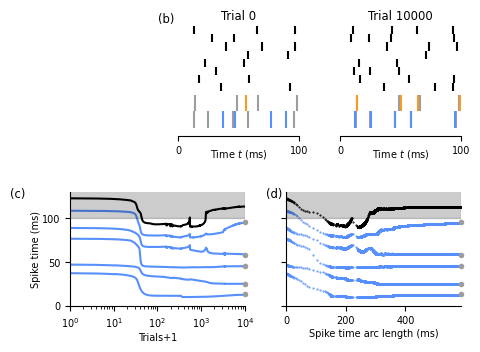

In [7]:
### Figure
fig = plt.figure(figsize=cm2inch(1.5 * 8.6, 1.5 * 6.0))
gs = gridspec.GridSpec(
    2,
    8,
    figure=fig,
    hspace=0.5,
    wspace=3.2,
    top=0.95,
    bottom=0.15,
    left=0.18,
    right=0.95,
)

### Spike raster before training
ax = fig.add_subplot(gs[0, 2:5])
plot_spikes(ax, examples, 0, config_qif)
panel_label(fig, ax, "(b)", x=-0.2, y=0.0)
# ax.set_ylabel("Neuron")

### Spike raster after training
ax = fig.add_subplot(gs[0, 5:8])
plot_spikes(ax, examples, 1, config_qif)

### Spike time neuron 0
ax = fig.add_subplot(gs[1, :4])
plot_times(ax, metrics, 0, config_qif)
ax.set_ylabel("Spike time (ms)", labelpad=1)
ax.set_xticks([1, 10, 100, 1000, 10000])
panel_label(fig, ax, "(c)", x=-0.6, y=-0.05)

### Spike time neuron 0 (arclength)
ax = fig.add_subplot(gs[1, 4:])
plot_times(ax, metrics, 0, config_qif, x="arclength", smoothing=1)
ax.set_yticklabels([])
panel_label(fig, ax, "(d)", x=-0.2, y=-0.05)

plt.show()

## Supplementary figures

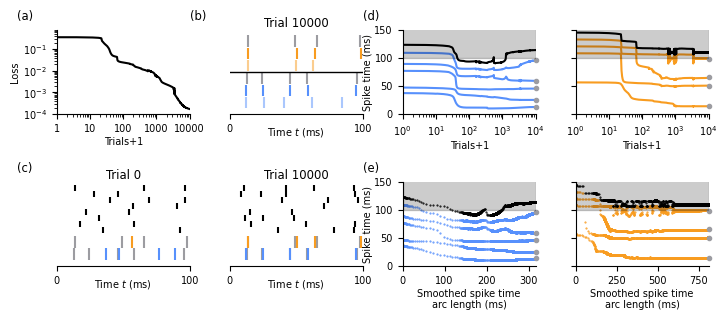

In [8]:
### Figure
fig = plt.figure(figsize=cm2inch(18.0, 8.0))
gs = gridspec.GridSpec(
    2,
    4,
    figure=fig,
    hspace=0.8,
    wspace=0.3,
    top=0.9,
    bottom=0.15,
    left=0.05,
    right=0.97,
)

### Loss
ax = fig.add_subplot(gs[0, 0])
plot_loss(ax, metrics, config_qif)
ax.set_ylim(1.0e-4, 0.8)
ax.set_xticks([1, 10, 100, 1000, 10000])
panel_label(fig, ax, "(a)", x=-0.4, y=0.1)

### Comparison of spike times
ax = fig.add_subplot(gs[0, 1])
plot_spikescomparison(ax, examples, config_qif)
panel_label(fig, ax, "(b)", x=-0.4, y=0.1)

### Spike raster before training
ax = fig.add_subplot(gs[1, 0])
plot_spikes(ax, examples, 0, config_qif)
panel_label(fig, ax, "(c)", x=-0.4, y=0.1)

### Spike raster after training
ax = fig.add_subplot(gs[1, 1])
plot_spikes(ax, examples, 1, config_qif)

### Spike time neuron 0
ax = fig.add_subplot(gs[0, 2])
plot_times(ax, metrics, 0, config_qif)
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_ylim(0, 1.5 * 10 * config_qif["T"])
ax.set_ylabel("Spike time (ms)", labelpad=1)
panel_label(fig, ax, "(d)", x=-0.4, y=0.1)

### Spike time neuron 1
ax = fig.add_subplot(gs[0, 3])
plot_times(ax, metrics, 1, config_qif, color="C1")
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_ylim(0, 1.5 * 10 * config_qif["T"])
ax.tick_params(labelleft=False)

### Spike time neuron 0 (arclength)
ax = fig.add_subplot(gs[1, 2])
plot_times(ax, metrics, 0, config_qif, x="arclength", smoothing=11)
ax.set_xlabel("Smoothed spike time\narc length (ms)")
ax.set_ylim(0, 1.5 * 10 * config_qif["T"])
ax.set_ylabel("Spike time (ms)", labelpad=1)
panel_label(fig, ax, "(e)", x=-0.4, y=0.1)

### Spike time neuron 1 (arclength)
ax = fig.add_subplot(gs[1, 3])
plot_times(ax, metrics, 1, config_qif, x="arclength", color="C1", smoothing=11)
ax.set_ylim(0, 1.5 * 10 * config_qif["T"])
ax.set_xlabel("Smoothed spike time\narc length (ms)")
ax.tick_params(labelleft=False)

plt.show()

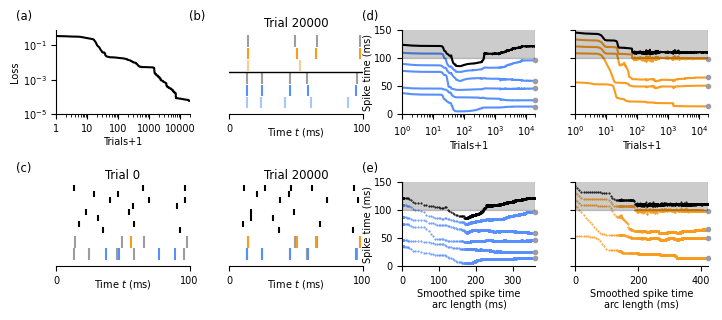

In [9]:
### Figure
fig = plt.figure(figsize=cm2inch(18.0, 8.0))
gs = gridspec.GridSpec(
    2,
    4,
    figure=fig,
    hspace=0.8,
    wspace=0.3,
    top=0.9,
    bottom=0.15,
    left=0.05,
    right=0.97,
)

### Loss
ax = fig.add_subplot(gs[0, 0])
plot_loss(ax, metrics_grid, config_qif_grid)
ax.set_ylim(1.0e-5, 0.8)
ax.set_xticks([1, 10, 100, 1000, 10000])
panel_label(fig, ax, "(a)", x=-0.4, y=0.1)

### Comparison of spike times
ax = fig.add_subplot(gs[0, 1])
plot_spikescomparison(ax, examples_grid, config_qif_grid)
panel_label(fig, ax, "(b)", x=-0.4, y=0.1)

### Spike raster before training
ax = fig.add_subplot(gs[1, 0])
plot_spikes(ax, examples_grid, 0, config_qif_grid)
panel_label(fig, ax, "(c)", x=-0.4, y=0.1)

### Spike raster after training
ax = fig.add_subplot(gs[1, 1])
plot_spikes(ax, examples_grid, 1, config_qif_grid)

### Spike time neuron 0
ax = fig.add_subplot(gs[0, 2])
plot_times(ax, metrics_grid, 0, config_qif_grid)
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_ylim(0, 1.5 * 10 * config_qif_grid["T"])
ax.set_ylabel("Spike time (ms)", labelpad=1)
panel_label(fig, ax, "(d)", x=-0.4, y=0.1)

### Spike time neuron 1
ax = fig.add_subplot(gs[0, 3])
plot_times(ax, metrics_grid, 1, config_qif_grid, color="C1")
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_ylim(0, 1.5 * 10 * config_qif_grid["T"])
ax.tick_params(labelleft=False)

### Spike time neuron 0 (arclength)
ax = fig.add_subplot(gs[1, 2])
plot_times(ax, metrics_grid, 0, config_qif_grid, x="arclength", smoothing=11)
ax.set_xlabel("Smoothed spike time\narc length (ms)")
ax.set_ylim(0, 1.5 * 10 * config_qif_grid["T"])
ax.set_ylabel("Spike time (ms)", labelpad=1)
panel_label(fig, ax, "(e)", x=-0.4, y=0.1)

### Spike time neuron 1 (arclength)
ax = fig.add_subplot(gs[1, 3])
plot_times(
    ax, metrics_grid, 1, config_qif_grid, x="arclength", smoothing=11, color="C1"
)
ax.set_ylim(0, 1.5 * 10 * config_qif_grid["T"])
ax.set_xlabel("Smoothed spike time\narc length (ms)")
ax.tick_params(labelleft=False)

plt.show()